In [4]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import os
import umap
import plotly.express as px
import plotly.graph_objects as go

import umap
from sklearn.decomposition import PCA
from sklearn.cluster import KMeans
from sklearn.linear_model import LinearRegression
from os.path import join as oj
from sklearn.mixture import BayesianGaussianMixture
from sklearn.ensemble import RandomForestClassifier



In [5]:
animal = 'RRM026'
session = 'Day176'
root_folder = r'/Users/yang/Documents/Wilbrecht_Lab/data4analysis/preprocessed_data'

'''
# following code block is used to extract assigned animal and session
animal_folder = oj(root_folder, animal)

dataframes = []

# Check if the animal folder exists
if os.path.isdir(animal_folder):
    session_folder = oj(animal_folder, session)
    if os.path.isdir(session_folder):
        for filename in os.listdir(session_folder):
            if filename.startswith(f'{animal}_{session}') and filename.endswith('_processed.csv'):
                file_path = oj(session_folder, filename)
                df = pd.read_csv(file_path, index_col=False)
                dataframes.append(df)
    else:
        print('No matching session folder found.')
else:
    print('No matching animal folder found.')

if dataframes:
    combined_df = pd.concat(dataframes, ignore_index=True)
else:
    print("No matching files found.")
    '''


'\n# following code block is used to extract assigned animal and session\nanimal_folder = oj(root_folder, animal)\n\ndataframes = []\n\n# Check if the animal folder exists\nif os.path.isdir(animal_folder):\n    session_folder = oj(animal_folder, session)\n    if os.path.isdir(session_folder):\n        for filename in os.listdir(session_folder):\n            if filename.startswith(f\'{animal}_{session}\') and filename.endswith(\'_processed.csv\'):\n                file_path = oj(session_folder, filename)\n                df = pd.read_csv(file_path, index_col=False)\n                dataframes.append(df)\n    else:\n        print(\'No matching session folder found.\')\nelse:\n    print(\'No matching animal folder found.\')\n\nif dataframes:\n    combined_df = pd.concat(dataframes, ignore_index=True)\nelse:\n    print("No matching files found.")\n    '

In [6]:
combined_df = pd.read_csv(oj(root_folder, 'combined_df.csv'), index_col=False)

In [7]:
print(combined_df.shape)
combined_df.head()

(1643207, 39)


,Unnamed: 0,Head x,Head y,Neck x,Neck y,Torso x,Torso y,Tailhead x,Tailhead y,warped Head x,...,Head velocity,Neck velocity,Torso velocity,Tailhead velocity,Head acceleration,Neck acceleration,Torso acceleration,Tailhead acceleration,animal,session
0,0,192.796951,28.332069,195.778046,23.389879,199.605362,11.785733,203.450699,6.817648,273.703649,...,0.000000,0.000000,0.000000,0.000000,6649.885821,4646.693069,4412.589343,590.246091,RRM028,Day141
1,1,192.110931,35.688915,195.196640,28.520031,199.130478,16.665558,203.038986,7.328142,274.235963,...,221.662861,154.889769,147.086311,19.674870,312.597565,2818.161807,3099.677421,4895.582548,RRM028,Day141
2,2,191.869446,43.421238,192.651031,36.414017,196.267807,24.506279,199.963287,12.590609,274.606919,...,232.082780,248.828496,250.408892,182.860955,-2067.092682,-755.839578,-671.529336,1497.167579,RRM028,Day141
3,3,191.725861,48.858665,192.430756,43.865223,195.759293,32.090069,199.434418,20.331448,275.048460,...,163.179690,223.633843,228.024581,232.766541,2402.980104,552.449666,-58.973204,-460.739103,RRM028,Day141
4,4,191.152802,56.947693,191.896271,51.915794,195.551804,39.622505,199.436478,27.578400,276.035795,...,243.279027,242.048832,226.058807,217.408570,-1.766716,-338.857171,218.826253,883.502202,RRM028,Day141


### over 92% trial length is greater than 37 frames (~1 second). also, most straight walking length is less than 30 frames. then we use the first 37 frames to cluster the trajectories.

In [8]:
current_trial_num = 1
current_decision = np.nan
current_restaurant = np.nan
decision = np.nan
current_length = 0
sum_of_speed = 0
speed_count = 0
coord_length = 37 # extract first 37 frames of coords of each trial

#bonsai_decision_list = []
decision_list = []
straight_walking_speed_list =[]
animal_list = []
session_list = []
trial_list = []
trial_lengths = []
current_head_coords = []
current_neck_coords = []
current_torso_coords = []
current_tailhead_coords = []
head_13_coords = []
neck_13_coords = []
torso_13_coords = []
tailhead_13_coords = []



for index, row in combined_df.iterrows():
    decision = row['decision']
    trial_num = row['trial']
    animal = row['animal']
    session = row['session']
    speed = row['Head velocity']
    restaurant = row['restaurant']
    head_x = row['warped Head x']
    head_y = row['warped Head y']
    neck_x = row['warped Neck x']
    neck_y = row['warped Neck y']
    torso_x = row['warped Torso x']
    torso_y = row['warped Torso y']
    tailhead_x = row['warped Tailhead x']
    tailhead_y = row['warped Tailhead y']

    if trial_num != current_trial_num: # Start of a new trial
        
        if speed_count != 0:
            average_speed = sum_of_speed/speed_count
        else:
            average_speed = np.nan
            
        if len(current_head_coords) >= coord_length * 2:
            head_13_coords.append(current_head_coords[:(coord_length * 2)])
            neck_13_coords.append(current_neck_coords[:(coord_length * 2)])
            torso_13_coords.append(current_torso_coords[:(coord_length * 2)])
            tailhead_13_coords.append(current_tailhead_coords[:(coord_length * 2)])
            decision_list.append(current_decision)
            straight_walking_speed_list.append(average_speed)
            animal_list.append(animal)
            session_list.append(session)
            trial_list.append(current_trial_num)
            trial_lengths.append(current_length)

        current_restaurant = restaurant
        current_decision = np.nan
        current_trial_num = trial_num 
        sum_of_speed = 0
        speed_count = 0
        current_length = 1
        current_head_coords = [head_x, head_y]
        current_neck_coords = [neck_x, neck_y]
        current_torso_coords = [torso_x, torso_y]
        current_tailhead_coords = [tailhead_x, tailhead_y]

    else: # Within trial
        current_length += 1
        current_head_coords.append(head_x)
        current_neck_coords.append(neck_x)
        current_torso_coords.append(torso_x)
        current_tailhead_coords.append(tailhead_x)
        current_head_coords.append(head_y)
        current_neck_coords.append(neck_y)
        current_torso_coords.append(torso_y)
        current_tailhead_coords.append(tailhead_y)
        
    if not pd.isna(decision): # Decision != None
        current_decision = decision
    
    if pd.isna(current_decision) and (speed < 300): # Straight walking speed
        sum_of_speed += speed
        speed_count += 1

head_columns = [f'head x{i//2+1}' if i % 2 == 0 else f'head y{i//2+1}' for i in range(coord_length * 2)]
neck_columns = [f'neck x{i//2+1}' if i % 2 == 0 else f'neck y{i//2+1}' for i in range(coord_length * 2)]
torso_columns = [f'torso x{i//2+1}' if i % 2 == 0 else f'torso y{i//2+1}' for i in range(coord_length * 2)]
tailhead_columns = [f'tailhead x{i//2+1}' if i % 2 == 0 else f'tailhead y{i//2+1}' for i in range(coord_length * 2)]
head_df = pd.DataFrame(head_13_coords, columns=head_columns)
neck_df = pd.DataFrame(neck_13_coords, columns=neck_columns)
torso_df = pd.DataFrame(torso_13_coords, columns=torso_columns)
tailhead_df = pd.DataFrame(tailhead_13_coords, columns=tailhead_columns)

other_df = pd.DataFrame({
    #'bonsai decision': bonsai_decision_list,
    'decision': decision_list,
    'straight_walking_speed': straight_walking_speed_list,
    'animal': animal_list,
    'session': session_list,
    'trial': trial_list,
    'trial_length': trial_lengths,
})

result_df = pd.concat([head_df, neck_df, torso_df, tailhead_df, other_df], axis=1)

In [9]:
result_df.head()

,head x1,head y1,head x2,head y2,head x3,head y3,head x4,head y4,head x5,head y5,...,tailhead x36,tailhead y36,tailhead x37,tailhead y37,decision,straight_walking_speed,animal,session,trial,trial_length
0,273.703649,130.625305,274.235963,124.023690,274.606919,117.536312,275.048460,111.118353,276.035795,104.365713,...,289.827452,41.866628,290.255173,40.070093,ACC,188.774688,RRM028,Day141,4.0,59
1,275.081359,131.457371,276.551920,125.745898,277.920257,119.725813,279.353280,113.663796,280.992563,107.857920,...,285.405963,49.062494,283.703906,47.214736,ACC,186.188321,RRM028,Day141,12.0,64
2,277.941905,130.312508,278.577533,123.949534,278.881523,117.752173,279.415347,112.051546,280.815795,106.384137,...,244.725160,32.745003,239.287219,32.633316,REJ,184.343255,RRM028,Day141,16.0,43
3,274.492893,135.458966,273.985886,135.097281,273.146888,134.716506,271.940633,134.231358,270.906057,133.488431,...,270.760182,127.688860,271.177497,127.241145,REJ,61.098888,RRM028,Day141,20.0,206
4,280.889106,129.981657,281.105503,125.876300,281.559156,121.832369,282.547442,117.152775,283.997059,111.611234,...,219.469208,31.867729,212.555992,30.404413,REJ,186.020492,RRM028,Day141,24.0,39


In [10]:
# Define the histogram
fig = px.histogram(result_df, x='trial_length', color='decision',
                   title='Distribution of Trial Lengths by Decision',
                   labels={'trial_length': 'Number of Frames per Trial'},
                   nbins=2000,  # Set number of bins
                   opacity=0.5)  # Set opacity for overlapping

# Customize layout
fig.update_layout(
    xaxis_title='Number of Frames per Trial',
    yaxis_title='Frequency',
    bargap=0.1,
    legend_title='Decision',
    template='plotly_white',
)
fig.update_xaxes(range=[0, 2000])
# Show the figure
fig.show()


In [11]:
decision_palette_dict = {
    "ACC": (0, 1, 0),  # Green with transparency
    "REJ": (1, 0, 0),  # Red with transparency
    "quit": (0, 0, 1),  # Blue with transparency
    "T-Entry": (1, 1, 1), # black
    np.nan: (1, 1, 1) # black
}
fig = go.Figure()
for index, row in result_df[:5000].iterrows():
    x_coords = [row[f'x{i}'] for i in range(1, 38)]
    y_coords = [row[f'y{i}'] for i in range(1, 38)]
    # Extract animal, session, and trial information
    decision, animal, session, trial = row['decision'], row['animal'], row['session'], row['trial']
    # Determine the color for the current trial
    color = 'rgba' + str(tuple(int(c * 255) for c in decision_palette_dict[decision]) + (0.2,))
    fig.add_trace(go.Scatter(
        x=x_coords, y=y_coords,
        mode='lines',
        name=f'Trial {row["trial"]}',
        line=dict(color=color, width=0.5),
    ))

fig.update_layout(
    title='Coordinates of Each Trial',
    xaxis_title='X Coordinates',
    yaxis_title='Y Coordinates',
    yaxis=dict(autorange='reversed'),
    showlegend=False,
)

fig.show()

KeyError: 'x1'

In [13]:
# Define the trajectory columns
umap_columns = [
    f'head x{i}' for i in range(1, 38)
] + [
    f'head y{i}' for i in range(1, 38)
] + [
    f'neck x{i}' for i in range(1, 38)
] + [
    f'neck y{i}' for i in range(1, 38)
] + [
    f'torso x{i}' for i in range(1, 38)
] + [
    f'torso y{i}' for i in range(1, 38)
] + [
    f'tailhead x{i}' for i in range(1, 38)
] + [
    f'tailhead y{i}' for i in range(1, 38)
]



# Extract the coordinate data
coords_data = result_df[umap_columns]

n_components = 5
n_clusters = 5

# Perform UMAP
reducer = umap.UMAP(n_components=n_components, random_state=42)
umap_components = reducer.fit_transform(coords_data)

# Create a DataFrame for the UMAP components
umap_columns = [f'UMAP{i+1}' for i in range(n_components)]
umap_df = pd.DataFrame(umap_components, columns=umap_columns)

# Add the UMAP components to the original DataFrame
coords_umap = pd.concat([result_df.reset_index(drop=True), umap_df.reset_index(drop=True)], axis=1)

# Scatter plot of UMAP1 and UMAP2 with decisions using Plotly
fig = px.scatter(coords_umap, x='UMAP1', y='UMAP2', color='decision',
                 title='Scatter Plot of UMAP1 and UMAP2 with Decision Distributions',
                 labels={'UMAP1': 'UMAP1', 'UMAP2': 'UMAP2'},
                 hover_data=['decision'])
fig.update_traces(marker=dict(size=2))
fig.show()

/opt/anaconda3/lib/python3.11/site-packages/umap/umap_.py:1945: UserWarning:

n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.



In [14]:
# Define the trajectory columns
pca_columns = [f'x{i}' for i in range(1, 38)] + [f'y{i}' for i in range(1, 38)]

# Extract the coordinate data
coords_data = result_df[pca_columns]

# Perform PCA
n_components = 3
pca = PCA(n_components=n_components)
principal_components = pca.fit_transform(coords_data)

# Create a DataFrame for the principal components
pc_columns = [f'PC{i+1}' for i in range(n_components)]
pc_df = pd.DataFrame(principal_components, columns=pc_columns)

# Add the principal components to the original DataFrame
speed_pca = pd.concat([result_df.reset_index(drop=True), pc_df.reset_index(drop=True)], axis=1)

# Scatter plot of PC1 and PC2 with decisions using Plotly
fig = px.scatter(speed_pca, x='PC1', y='PC2', color='decision',
                 title='Scatter Plot of PC1 and PC2 with Decision Distributions',
                 labels={'PC1': 'PC1', 'PC2': 'PC2'},
                 hover_data=['decision'])
fig.update_traces(marker=dict(size=2))
fig.show()

# Plot the explained variance
explained_variance = pca.explained_variance_ratio_
plt.figure(figsize=(10, 6))
plt.bar(range(1, n_components + 1), explained_variance, tick_label=pc_columns)
plt.xlabel('Principal Components')
plt.ylabel('Explained Variance Ratio')
plt.title('Variance Explained by Each Principal Component')
plt.show()

# Show the formula for each PC
components = pca.components_

# Create formulas for each PC
feature_names = coords_data.columns
pc_formulas = {}
for i in range(n_components):
    formula = " + ".join([f"{components[i, j]:.2f}*{feature_names[j]}" for j in range(len(feature_names))])
    pc_formulas[f'PC{i+1}'] = formula

# Create formulas for each PC
feature_names = coords_data.columns
pc_formulas = {}
for i in range(n_components):
    formula = " + ".join([f"{components[i, j]:.2f}*{feature_names[j]}" for j in range(len(feature_names))])
    pc_formulas[f'PC{i+1}'] = formula

# Create a DataFrame for the weights
weights_df = pd.DataFrame(components.T, index=feature_names, columns=pc_columns)

# Plot the weights for each principal component
plt.figure(figsize=(15, 8))
for pc in pc_columns:
    plt.plot(weights_df.index, weights_df[pc], label=pc, marker='o')

plt.xlabel('Features')
plt.ylabel('Weights')
plt.title('Weights of Features in Each Principal Component')
plt.xticks(rotation=90)
plt.legend()
plt.grid(True)
plt.show()

KeyError: "None of [Index(['x1', 'x2', 'x3', 'x4', 'x5', 'x6', 'x7', 'x8', 'x9', 'x10', 'x11',\n       'x12', 'x13', 'x14', 'x15', 'x16', 'x17', 'x18', 'x19', 'x20', 'x21',\n       'x22', 'x23', 'x24', 'x25', 'x26', 'x27', 'x28', 'x29', 'x30', 'x31',\n       'x32', 'x33', 'x34', 'x35', 'x36', 'x37', 'y1', 'y2', 'y3', 'y4', 'y5',\n       'y6', 'y7', 'y8', 'y9', 'y10', 'y11', 'y12', 'y13', 'y14', 'y15', 'y16',\n       'y17', 'y18', 'y19', 'y20', 'y21', 'y22', 'y23', 'y24', 'y25', 'y26',\n       'y27', 'y28', 'y29', 'y30', 'y31', 'y32', 'y33', 'y34', 'y35', 'y36',\n       'y37'],\n      dtype='object')] are in the [columns]"

of both dim deduction:
reject trials are clearly defferentiated from others.
accept and quit trials are partially merged.

implications from PCA results:
PC1 emphasis on x coord after T-Entry, defferentiating between REJ and others.
PC2 emphasis on y coord after T-Entry, partially defferentiating between ACC and quit.
UMAP probably has the similar idea.

generally, UMAP is spliting the decision better than PCA.

Future implication:
use GMM or other non-circular probabilistic clustering model to give a score for each trial, then look at the effect of this score on the classification of neural activity.

In [ ]:
coords_umap.head()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,straight_walking_speed,animal,session,trial,trial_length,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5
0,297.271604,125.932236,297.810956,119.994282,298.240149,113.552809,298.339819,106.815038,298.074981,100.134950,...,150.649940,RRM028,Day136,1,159,9.946659,9.964302,4.753528,4.441462,6.410887
1,289.563935,128.447126,290.005645,122.230493,290.581654,115.873554,291.508640,109.050360,292.761309,101.645353,...,229.864156,RRM028,Day136,5,46,11.286277,11.226248,6.756753,2.611355,6.462329
2,293.917806,126.046794,293.697025,121.348562,293.512995,116.439108,293.405168,111.175115,293.394795,105.557408,...,185.055303,RRM028,Day136,9,46,11.673298,10.947907,6.530645,2.718775,7.396495
3,286.956016,131.687361,288.450812,127.777012,289.553869,123.526205,290.203186,118.759048,290.553729,113.821701,...,150.978190,RRM028,Day136,13,169,10.512636,8.887232,3.442776,4.953256,6.975785
4,286.481579,129.104102,288.540240,125.478926,289.323751,121.775837,289.905958,117.851038,291.111284,113.488322,...,164.766663,RRM028,Day136,17,48,11.345567,9.840544,4.868778,4.139873,7.590088


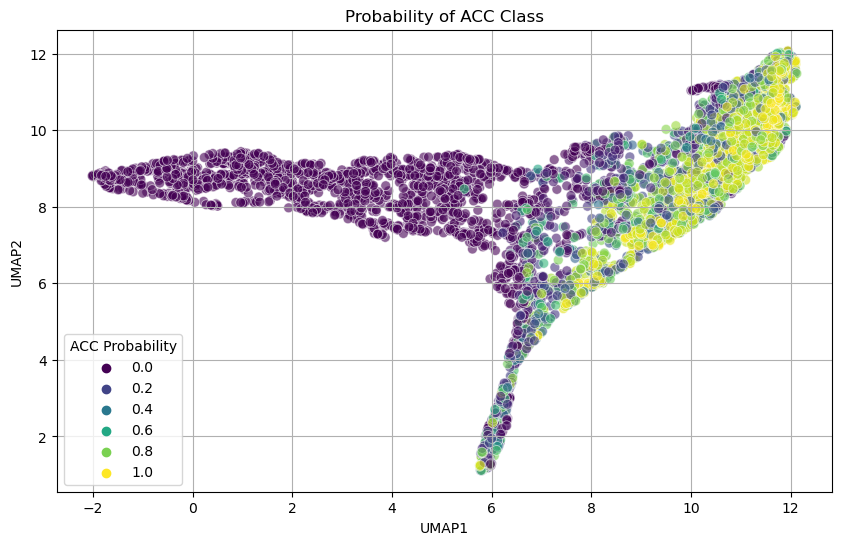

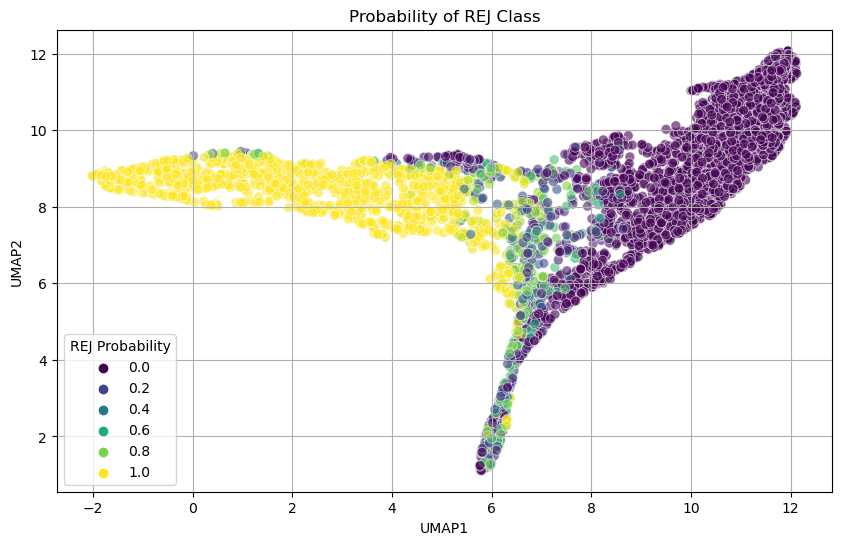

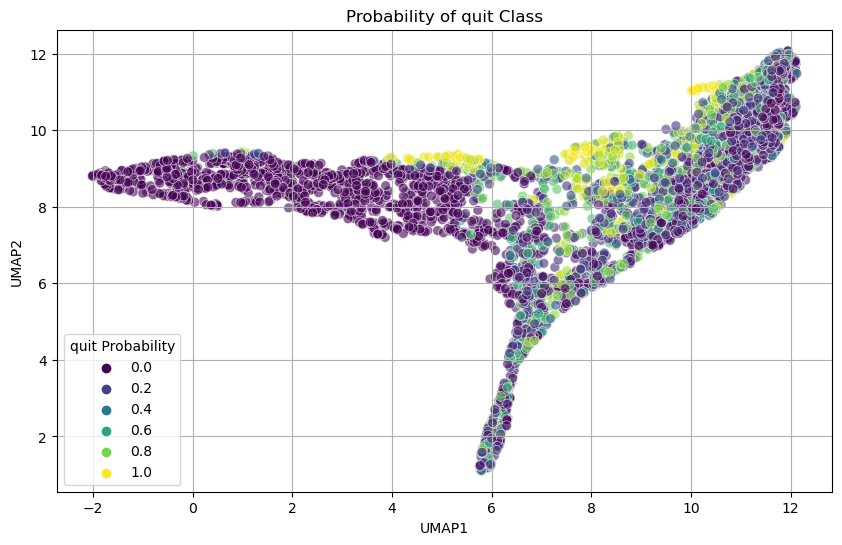

In [ ]:
coords_umap_clean = coords_umap.dropna(subset=['UMAP1', 'UMAP2', 'decision'])

desired_decisions = ['ACC', 'REJ', 'quit']
coords_umap_filtered = coords_umap_clean[coords_umap_clean['decision'].isin(desired_decisions)]

X = coords_umap_filtered[['UMAP1', 'UMAP2']]
y = coords_umap_filtered['decision']

rf = RandomForestClassifier(n_estimators=100, random_state=42)
rf.fit(X, y)

probs = rf.predict_proba(X)
probs_df = pd.DataFrame(probs, columns=[f'{cls}_prob' for cls in rf.classes_])
coords_umap_filtered = pd.concat([coords_umap_filtered.reset_index(drop=True), probs_df], axis=1)

labels = rf.predict(X)
coords_umap_filtered['Predicted'] = labels

# Plot the probabilities for each class
for cls in rf.classes_:
    plt.figure(figsize=(10, 6))
    sns.scatterplot(x='UMAP1', y='UMAP2', hue=f'{cls}_prob', data=coords_umap_filtered, palette='viridis', s=50, alpha=0.6, edgecolor='w')
    plt.title(f'Probability of {cls} Class')
    plt.xlabel('UMAP1')
    plt.ylabel('UMAP2')
    plt.legend(title=f'{cls} Probability')
    plt.grid(True)
    plt.show()

In [ ]:
coords_umap_filtered.describe()

,x1,y1,x2,y2,x3,y3,x4,y4,x5,y5,...,trial,trial_length,UMAP1,UMAP2,UMAP3,UMAP4,UMAP5,ACC_prob,REJ_prob,quit_prob
count,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,...,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000,6545.000000
mean,287.436240,130.166579,287.909936,125.629210,288.357585,120.847408,288.807903,115.839020,289.257781,110.642948,...,126.625057,125.677464,7.970394,8.608644,3.179355,3.714645,5.449339,0.460468,0.284368,0.255164
std,6.233964,5.361144,6.023433,5.503777,5.864778,6.651740,5.702387,8.012638,5.515266,9.314989,...,84.722389,356.535198,3.627868,2.103112,2.173055,1.139037,1.183827,0.406594,0.424923,0.319732
min,259.188811,-25.032617,259.434974,-13.861041,259.596711,-19.015822,259.689908,-22.625521,259.648770,-24.891025,...,1.000000,37.000000,-2.015037,1.104548,-0.876032,1.416750,3.257915,0.000000,0.000000,0.000000
25%,284.126417,128.840462,284.542057,123.183762,284.974860,117.611155,285.383903,111.413896,285.761571,105.103402,...,57.000000,47.000000,6.065749,7.820387,1.638977,2.851119,4.466388,0.010000,0.000000,0.010000
50%,287.966857,130.212735,288.387523,125.626705,288.810510,120.956619,289.323985,115.728563,289.767907,110.377859,...,116.000000,53.000000,9.250976,8.849526,2.700180,3.796285,5.550194,0.320000,0.000000,0.090000
75%,291.854778,132.048025,292.162841,128.354618,292.446432,124.520113,292.693435,120.436430,292.963451,116.103400,...,184.000000,88.000000,10.901552,9.996299,4.975216,4.652102,6.423132,0.890000,0.800000,0.590000
max,320.338355,144.320706,322.439202,144.013452,326.601262,143.499719,323.050853,143.060109,321.940052,145.087189,...,409.000000,12234.000000,12.120455,12.076194,7.967213,5.888589,7.926531,1.000000,1.000000,1.000000
